# QTT Demo

Notebook demonstrating the primary functionality of the Quantum Threat Tracker (QTT).

The core functionality of the QTT is to forecast when certain public-key cryptographic protocols such as RSA may be broken by quantum computers via Shor's algorithm. In this notebook, we demonstrate how to use the QTT to generate such forecasts of the quantum threat. We will show how to:
- Create a prediction of the future of quantum computing hardware, called a *hardware roadmap*.
- Use the hardware roadmap to predict when certain cryptographic protocols will be broken.
- Plot the cryptographic protocols according to when the QTT expects them to be broken.

## Quantum hardware roadmaps

To estimate when real quantum computers will be capable of breaking certain cryptographic protocols, the QTT needs a projection into the future of where we expect quantum computing hardware to be at certain points in the future. We call this projection a hardware roadmap.

Structurally, the hardware roadmap is a collection of future timestamps, paired with descriptions of what quantum computers we expect to have available at each timestamp. The technical specifications of the quantum computers are entirely defined in `qsharp`'s `EstimatorParams` class.

For example, let us say we expect to have a superconducting quantum computer with 1,000,000 physical qubits in the year 2040. We can create a hardware roadmap containing this data point as follows.

In [1]:
from qsharp.estimator import EstimatorParams

from quantumthreattracker.lifespan_estimator import HardwareRoadmap

hardware_roadmap = HardwareRoadmap()

timestamp = 2208988800  # unix timestamp for the year 2040

params = EstimatorParams()
params.qubit_params.name = "qubit_gate_ns_e4"  # qsharp's default parameters for superconducting qubits
params.constraints.max_physical_qubits = 1e6

hardware_roadmap.add(timestamp=timestamp, estimator_params=params)

We can view the hardware roadmap by calling the `as_list()` method:

In [2]:
hardware_roadmap.as_list()

[{'timestamp': 2208988800,
  'hardwareList': [{'estimatorParams': {'qubitParams': {'name': 'qubit_gate_ns_e4'},
     'constraints': {'maxPhysicalQubits': 1000000.0}}}]}]

Let us move on to constructing a hardware roadmap with multiple entries. For this example, we will assume that the operational parameters for superconducting quantum computers (gate times, gate error rates, etc.) stay constant whilst the qubit count follows Moore's law (doubling every two years). Note however that this is highly customisable, as any parameter present in the `EstimatorParams` class can be altered to describe other quantum computers in the hardware roadmap.

In [3]:
hardware_roadmap = HardwareRoadmap()

for i in range(20):
    params.constraints.max_physical_qubits = 1000 * (2**i)
    hardware_roadmap.add(timestamp=1735689600 + 31536000 * 2 * i, estimator_params=params)

## Estimating the remaining lifespans of cryptographic protocols

Now that we have a hardware roadmap, we can use this information to estimate when quantum computers will be capable of breaking certain cryptographic protocols. First, we need to initialise an instance of the `LifespanEstimator` class, which offers this functionality. During initialisation, we give it the hardware roadmap we created earlier.

In [4]:
from quantumthreattracker.lifespan_estimator import LifespanEstimator

lifespan_estimator = LifespanEstimator(hardware_roadmap)

Next, we need to specify a list of cryptographic protocols and key sizes. This is given as a list of dictionaries. For example, say we are interested in the RSA protocol for key sizes from 512 to 8192. We define our list of protocols of interest as follows.

In [ ]:
protocols = [
    {"algorithm": "RSA", "keySize": 1024},
    {"algorithm": "RSA", "keySize": 2048},
    {"algorithm": "RSA", "keySize": 4096},
    {"algorithm": "RSA", "keySize": 8192},
    {"algorithm": "DH-SP", "keySize": 2048},
    {"algorithm": "DH-SP", "keySize": 4096},
    {"algorithm": "DH-SP", "keySize": 8192},
    {"algorithm": "DH-SCH", "keySize": 2048},
    {"algorithm": "ECDH", "keySize": 256},
    {"algorithm": "ECDH", "keySize": 384},
    {"algorithm": "ECDH", "keySize": 512},
    ]

Next, we generate the 'threat report' using the `generate_report` method. This makes many quantum resource estimates and so may take a while to run depending on the algorithm implementation, number of entries in the hardware roadmap, key sizes, etc.

In [6]:
lifespan_estimator.generate_report(protocols=protocols)

We can view the threat report using the `get_report` method.

Note that in general there are several threats associated with each cryptographic protocol. This is because there are many degrees of freedom in choosing the space-time tradeoff when implementing Shor's algorithm. For example, some implementations may use fewer qubits but take longer to run compared to others. Thus, the QTT outputs all possible threats, including those which minimise qubit count and those which minimise algorithm runtime.

The `soonest_threat_only` argument in the `get_report` function removes all threats in the threat lists except those with the soonest timestamp. Here we display the data with this option enabled for readability.

In [7]:
lifespan_estimator.get_report(detail_level=1, soonest_threat_only=True)

[{'protocol': 'RSA-1024',
  'threats': [{'timestamp': 2429481600, 'runtime': 9027209769600}]},
 {'protocol': 'RSA-2048',
  'threats': [{'timestamp': 2555625600, 'runtime': 47839489588800}]},
 {'protocol': 'RSA-4096',
  'threats': [{'timestamp': 2618697600, 'runtime': 301441273036800}]},
 {'protocol': 'RSA-8192',
  'threats': [{'timestamp': 2681769600, 'runtime': 3401211242520000}]},
 {'protocol': 'DH-SP-2048',
  'threats': [{'timestamp': 2555625600, 'runtime': 22317642547200}]},
 {'protocol': 'DH-SP-4096',
  'threats': [{'timestamp': 2618697600, 'runtime': 44745188966400}]},
 {'protocol': 'DH-SP-8192',
  'threats': [{'timestamp': 2681769600, 'runtime': 1450790092800000}]},
 {'protocol': 'DH-SCH-2048',
  'threats': [{'timestamp': 2492553600, 'runtime': 5069387188800}]},
 {'protocol': 'ECDH-224',
  'threats': [{'timestamp': 2429481600, 'runtime': 10466238684000}]},
 {'protocol': 'ECDH-256',
  'threats': [{'timestamp': 2429481600, 'runtime': 12203705571200}]},
 {'protocol': 'ECDH-384',
  

The QTT is also able to graphically represent its output by calling `plot_threats()`.

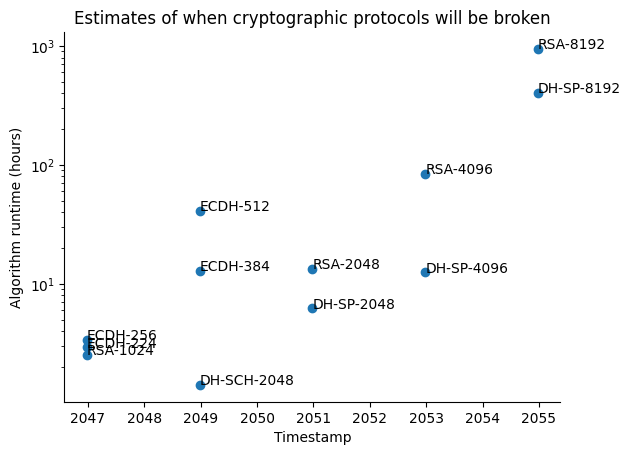

In [8]:
import matplotlib.pyplot as plt

ax = lifespan_estimator.plot_threats()
plt.show()